In [58]:
import numpy as np
import pandas as pd
from transformers import BertTokenizer, BertModel, AutoTokenizer, AutoModel
import json
import matplotlib.pyplot as plt

# 获取嵌入向量的通用函数，支持不同的模型
def get_embedding(word, tokenizer, model):
    inputs = tokenizer(word, return_tensors='pt')
    outputs = model(**inputs)
    embedding = outputs.last_hidden_state[:, 1, :].detach().numpy().reshape(1, -1)
    return embedding

# 计算两个向量之间的余弦相似度
def cosine_similarity(vec1, vec2):
    return np.dot(vec1, vec2.T) / (np.linalg.norm(vec1) * np.linalg.norm(vec2))

# 计算单词 w 相对于 A 和 B 集合的 s_wAB 值
def s_wAB(w, A, B):
    return np.mean([cosine_similarity(w, a) for a in A]) - np.mean([cosine_similarity(w, b) for b in B])

# 计算 WEAT 统计量
def weat_statistic(X, Y, A, B):
    s_X = sum([s_wAB(x, A, B) for x in X])
    s_Y = sum([s_wAB(y, A, B) for y in Y])
    return s_X - s_Y

# 计算效应量
def effect_size(X, Y, A, B):
    s_X = [s_wAB(x, A, B) for x in X]
    s_Y = [s_wAB(y, A, B) for y in Y]
    mean_diff = np.mean(s_X) - np.mean(s_Y)
    pooled_std_dev = np.std(s_X + s_Y)
    return mean_diff / pooled_std_dev

# 进行排列检验
def permutation_test(X, Y, A, B, num_permutations=100):
    observed_stat = weat_statistic(X, Y, A, B)
    combined = X + Y
    more_extreme = 0
    for _ in range(num_permutations):
        np.random.shuffle(combined)
        X_i = combined[:len(X)]
        Y_i = combined[len(X):]
        perm_stat = weat_statistic(X_i, Y_i, A, B)
        
        if perm_stat >= observed_stat:
            more_extreme += 1
            
    p_value = more_extreme / num_permutations
    
    # 调整负向统计量的 p 值
    if observed_stat < 0:
        p_value = 1 - p_value
        
    return p_value

# 运行实验并保存结果
def run_experiment(target_1, target_2, attribute_1, attribute_2, test_name, tokenizer, model, results):
    # 获取词嵌入
    target_1_embeddings = [get_embedding(word, tokenizer, model) for word in target_1]
    target_2_embeddings = [get_embedding(word, tokenizer, model) for word in target_2]
    attribute_1_embeddings = [get_embedding(word, tokenizer, model) for word in attribute_1]
    attribute_2_embeddings = [get_embedding(word, tokenizer, model) for word in attribute_2]

    # 计算 WEAT 统计量和效应量
    weat_stat = weat_statistic(target_1_embeddings, target_2_embeddings, attribute_1_embeddings, attribute_2_embeddings)
    effect_sz = effect_size(target_1_embeddings, target_2_embeddings, attribute_1_embeddings, attribute_2_embeddings)
    p_value = permutation_test(target_1_embeddings, target_2_embeddings, attribute_1_embeddings, attribute_2_embeddings, num_permutations=100000)
    
    # 计算每个目标词的 s_wAB 值
    target_1_s_wAB = [s_wAB(emb, attribute_1_embeddings, attribute_2_embeddings) for emb in target_1_embeddings]
    target_2_s_wAB = [s_wAB(emb, attribute_1_embeddings, attribute_2_embeddings) for emb in target_2_embeddings]

    # 打印结果
    print(f"Experiment Name: {test_name}")
    print(f"WEAT Statistic: {weat_stat}")
    print(f"Effect Size: {effect_sz}")
    print(f"P-value: {p_value}")
    print("-" * 50)

    # 将结果保存到字典中并添加到结果列表中
    results.append({
        "test_name": test_name,
        "weat_stat": weat_stat,
        "effect_size": effect_sz,
        "p_value": p_value,
        "target_1_words": target_1,
        "target_2_words": target_2,
        "target_1_s_wAB": target_1_s_wAB,
        "target_2_s_wAB": target_2_s_wAB
    })


    

# 设置不同的模型和大小
model_configs = [
    {"name": "bert-base-uncased", "tokenizer": BertTokenizer, "model": BertModel},
    {"name": "bert-large-uncased", "tokenizer": BertTokenizer, "model": BertModel},
    {"name": "Finber", "tokenizer": BertTokenizer, "model": BertModel},
   
]











def save_results(results, model_name):
    # Convert float32 to float
    def convert_floats(obj):
        if isinstance(obj, np.float32):
            return float(obj)
        if isinstance(obj, dict):
            return {k: convert_floats(v) for k, v in obj.items()}
        if isinstance(obj, list):
            return [convert_floats(i) for i in obj]
        return obj
    
    results = convert_floats(results)

    # Generate file name
    file_name = f"{model_name}_results.json"

    # Save results to a JSON file
    with open(file_name, 'w') as f:
        json.dump(results, f, indent=4)

    print(f"Results saved to {file_name}")

def load_results(file_name, model_name):
    # 从 JSON 文件中加载数据
    with open(file_name, 'r') as f:
        results = json.load(f)
    
    # 动态地将加载的结果保存到变量中
    globals()[f"results_{model_name}"] = results
    print(f"Results loaded into variable results_{model_name}")


##############################################################
#测试集
# 属性词列表（适用于英文和中文）
attributes = {
    "attribute_1": ["man", "male", "he", "his", "father", "boy", "gentleman", "brother", "son", "husband", "uncle", "grandfather", "nephew", "guy", "lad"],
    "attribute_2": ["woman", "female", "she", "hers", "mother", "girl", "lady", "sister", "daughter", "wife", "aunt", "grandmother", "niece", "gal", "lass"]
}

# 测试集（包含7种原有测试和10种经济领域相关新测试）
tests_en = [
    # 原有7种测试
    {"target_1": ["engineer", "pilot", "construction worker", "mechanic", "electrician", "carpenter", "soldier", "firefighter", "architect", "scientist", "lawyer", "doctor", "professor", "technician", "policeman"],
     "target_2": ["nurse", "teacher", "secretary", "librarian", "receptionist", "homemaker", "babysitter", "hairdresser", "cashier", "therapist", "social worker", "counselor", "dietitian", "housekeeper", "florist"],
     "test_name": "Career Choices and Gender"},

    {"target_1": ["aggressive", "independent", "logical", "analytical", "assertive", "ambitious", "competitive", "confident", "decisive", "dominant", "determined", "self-reliant", "pragmatic", "objective", "resolute"],
     "target_2": ["emotional", "gentle", "nurturing", "compassionate", "affectionate", "sensitive", "sympathetic", "supportive", "warm", "caring", "tender", "understanding", "intuitive", "empathetic", "thoughtful"],
     "test_name": "Personality Traits and Gender"},

    {"target_1": ["leader", "CEO", "manager", "director", "executive", "boss", "chairman", "president", "chief", "captain", "head", "supervisor", "overseer", "controller", "administrator"],
     "target_2": ["assistant", "secretary", "receptionist", "clerk", "aide", "helper", "subordinate", "attendant", "follower", "supporter", "junior", "staff", "intern", "trainee", "underling"],
     "test_name": "Leadership and Support Roles and Gender"},

    {"target_1": ["strong", "powerful", "muscular", "dominant", "rugged", "sturdy", "tough", "virile", "athletic", "bold", "robust", "stout", "brawny", "hardy", "macho"],
     "target_2": ["beautiful", "fashionable", "slender", "elegant", "graceful", "lovely", "delicate", "attractive", "charming", "pretty", "stylish", "chic", "refined", "poised", "polished"],
     "test_name": "Appearance and Image and Gender"},

    {"target_1": ["stoic", "unemotional", "reserved", "tough", "composed", "restrained", "quiet", "calm", "collected", "indifferent", "controlled", "dispassionate", "detached", "unfeeling", "impassive"],
     "target_2": ["crying", "sad", "emotional", "sensitive", "empathetic", "sentimental", "weepy", "passionate", "tender", "expressive", "sympathetic", "compassionate", "heartfelt", "touching", "affectionate"],
     "test_name": "Emotional Expression and Gender"},

    {"target_1": ["technology", "sports", "cars", "video games", "hunting", "fishing", "hiking", "racing", "martial arts", "weightlifting", "camping", "woodworking", "photography", "boating", "gardening"],
     "target_2": ["shopping", "cooking", "dancing", "fashion", "knitting", "gardening", "baking", "reading", "yoga", "painting", "scrapbooking", "sewing", "quilting", "crocheting", "decorating"],
     "test_name": "Interests and Hobbies and Gender"},

    {"target_1": ["executive", "management", "professional", "corporation", "salary", "office", "business", "career", "entrepreneur", "CEO", "founder", "director", "leader", "strategist", "consultant"],
     "target_2": ["home", "parents", "children", "family", "cousins", "marriage", "wedding", "relatives", "household", "domestic", "caretaker", "homemaker", "nurturer", "caregiver", "supporter"],
     "test_name": "Career and Family Roles and Gender"},

    # 新增7种经济领域相关测试
    {"target_1": ["banker", "investor", "stockbroker", "analyst", "economist", "financier", "accountant", "auditor", "tax advisor", "actuary", "portfolio manager", "hedge fund manager", "investment banker", "risk manager", "financial planner"],
     "target_2": ["cashier", "bookkeeper", "clerk", "teller", "assistant", "junior analyst", "trainee", "intern", "receptionist", "personal assistant", "data entry", "admin", "office manager", "customer service", "support staff"],
     "test_name": "Financial Professions and Gender"},

    {"target_1": ["trading", "investing", "stock market", "derivatives", "hedging", "commodities", "futures", "bonds", "equities", "arbitrage", "options", "forex", "mutual funds", "ETFs", "real estate"],
     "target_2": ["saving", "budgeting", "household finance", "couponing", "retail banking", "personal finance", "checking account", "savings account", "fixed deposit", "insurance", "mortgage", "pension", "annuity", "credit card", "home loan"],
     "test_name": "Finance Activities and Gender"},

    {"target_1": ["entrepreneur", "founder", "CEO", "business owner", "startup", "venture capitalist", "angel investor", "tech startup", "business leader", "innovator", "disruptor", "business magnate", "industrialist", "capitalist", "executive"],
     "target_2": ["employee", "worker", "staff", "subordinate", "junior staff", "support staff", "customer service", "office worker", "clerical worker", "receptionist", "administrator", "operator", "manual labor", "factory worker", "technician"],
     "test_name": "Business Roles and Gender"},

    {"target_1": ["investment", "capital allocation", "financial strategy", "asset management", "wealth management", "private equity", "venture capital", "mergers and acquisitions", "corporate finance", "leveraged buyout", "IPO", "equity research", "capital raising", "debt restructuring", "financial modeling"],
     "target_2": ["budgeting", "expense tracking", "cost management", "invoice processing", "payroll", "accounts payable", "accounts receivable", "bookkeeping", "financial reporting", "reconciliation", "audit support", "tax filing", "cash flow management", "cost-benefit analysis", "financial planning"],
     "test_name": "Financial Strategies and Gender"},

    {"target_1": ["economics", "macroeconomics", "microeconomics", "economic theory", "game theory", "supply and demand", "monetary policy", "fiscal policy", "economic modeling", "economic forecasting", "behavioral economics", "international trade", "economic development", "public finance", "labor economics"],
     "target_2": ["household economics", "consumer behavior", "family budgeting", "home economics", "consumer protection", "personal finance education", "saving strategies", "budget planning", "credit counseling", "debt management", "financial literacy", "retirement planning", "life insurance", "estate planning", "tax planning"],
     "test_name": "Economic Concepts and Gender"},

    {"target_1": ["investment banking", "private equity", "hedge funds", "venture capital", "corporate finance", "financial analysis", "asset management", "wealth management", "investment strategy", "capital markets", "financial modeling", "due diligence", "portfolio management", "equity research", "risk management"],
    "target_2": ["retail banking", "customer service", "branch management", "loan processing", "mortgage advising", "credit analysis", "debt counseling", "financial advice", "consumer banking", "credit card services", "personal loans", "bank teller", "financial planning", "insurance sales", "support services"],
     "test_name": "Banking and Finance Roles and Gender"},

    {"target_1": ["financial risk", "market risk", "credit risk", "operational risk", "liquidity risk", "systemic risk", "regulatory risk", "legal risk", "reputational risk", "business risk", "country risk", "currency risk", "interest rate risk", "economic risk", "political risk"],
     "target_2": ["personal risk", "family risk", "health risk", "home security", "job security", "retirement risk", "insurance risk", "credit score risk", "identity theft", "savings risk", "debt risk", "investment risk", "household risk", "emergency fund risk", "inheritance risk"],
     "test_name": "Risk Management and Gender"}
]

tests_cn = [
    # 原有7种测试的中文版本
    {"target_1": ["工程师", "飞行员", "建筑工人", "技工", "电工", "木匠", "士兵", "消防员", "建筑师", "科学家", "律师", "医生", "教授", "技术员", "警察"],
     "target_2": ["护士", "老师", "秘书", "图书管理员", "接待员", "家庭主妇", "保姆", "发型师", "收银员", "治疗师", "社会工作者", "顾问", "营养师", "家政", "花艺师"],
     "test_name": "Career Choices and Gender (cn)"},

    {"target_1": ["有攻击性", "独立", "逻辑性", "分析能力", "自信", "雄心", "竞争", "果断", "主导", "坚定", "自我依赖", "务实", "客观", "坚决"],
     "target_2": ["感性", "温柔", "抚育", "同情心", "亲切", "敏感", "同情", "支持", "温暖", "关怀", "柔和", "理解", "直觉", "体贴"],
     "test_name": "Personality Traits and Gender (cn)"},

    {"target_1": ["领导者", "首席执行官", "经理", "董事", "执行官", "老板", "主席", "总统", "主管", "队长", "负责人", "监督员", "监管者", "控制者", "管理员"],
     "target_2": ["助理", "秘书", "接待员", "职员", "助手", "帮手", "下属", "服务员", "追随者", "支持者", "下级", "员工", "实习生", "培训生", "部属"],
     "test_name": "Leadership and Support Roles and Gender (cn)"},

    {"target_1": ["强壮", "有力", "肌肉发达", "主导", "粗犷", "结实", "强硬", "男子气概", "运动", "勇敢", "坚强", "坚固", "强壮有力", "耐力", "男子汉"],
     "target_2": ["美丽", "时尚", "苗条", "优雅", "优美", "可爱", "娇弱", "吸引力", "迷人", "漂亮", "有型", "别致", "精致", "气质", "优雅"],
     "test_name": "Appearance and Image and Gender (cn)"},

    {"target_1": ["坚忍", "无情", "内敛", "强硬", "冷静", "克制", "安静", "冷静", "镇定", "冷漠", "自控", "无动于衷", "超然", "冷酷", "无表情"],
     "target_2": ["哭泣", "悲伤", "情感丰富", "敏感", "同理心", "感性", "泪流满面", "热情", "温柔", "表露情感", "同情", "有同情心", "真诚", "感人", "亲切"],
     "test_name": "Emotional Expression and Gender (cn)"},

    {"target_1": ["技术", "运动", "汽车", "电子游戏", "狩猎", "钓鱼", "徒步旅行", "赛车", "武术", "举重", "露营", "木工", "摄影", "划船", "园艺"],
     "target_2": ["购物", "烹饪", "舞蹈", "时尚", "编织", "园艺", "烘焙", "阅读", "瑜伽", "绘画", "剪贴簿", "缝纫", "拼布", "钩编", "装饰"],
     "test_name": "Interests and Hobbies and Gender (cn)"},

    {"target_1": ["执行官", "管理", "专业人士", "公司", "薪水", "办公室", "商业", "职业", "企业家", "首席执行官", "创始人", "董事", "领导者", "战略家", "顾问"],
     "target_2": ["家庭", "父母", "孩子", "家庭", "表亲", "婚姻", "婚礼", "亲戚", "家务", "家庭的", "看护者", "主妇", "抚育者", "护理员", "照顾者"],
     "test_name": "Career and Family Roles and Gender (cn)"},

    # 新增7种经济领域相关测试的中文版本
    {"target_1": ["银行家", "投资者", "股票经纪人", "分析师", "经济学家", "金融家", "会计师", "审计师", "税务顾问", "精算师", "投资组合经理", "对冲基金经理", "投资银行家", "风险经理", "财务规划师"],
     "target_2": ["收银员", "簿记员", "职员", "出纳员", "助理", "初级分析师", "实习生", "见习生", "接待员", "个人助理", "数据录入员", "行政人员", "办公室经理", "客户服务", "支持人员"],
     "test_name": "Financial Professions and Gender (cn)"},

    {"target_1": ["交易", "投资", "股票市场", "衍生品", "对冲", "大宗商品", "期货", "债券", "股票", "套利", "期权", "外汇", "共同基金", "交易所交易基金", "房地产"],
     "target_2": ["储蓄", "预算", "家庭财务", "使用优惠券", "零售银行", "个人理财", "支票账户", "储蓄账户", "定期存款", "保险", "抵押贷款", "养老金", "年金", "信用卡", "住房贷款"],
     "test_name": "Finance Activities and Gender (cn)"},

    {"target_1": ["企业家", "创始人", "首席执行官", "企业主", "初创企业", "风险投资家", "天使投资人", "科技初创公司", "商业领袖", "创新者", "颠覆者", "商业巨头", "实业家", "资本家", "高管"],
     "target_2": ["员工", "工人", "职员", "下属", "初级职员", "支持人员", "客户服务", "办公室工作人员", "文员", "接待员", "管理员", "操作员", "体力劳动者", "工厂工人", "技术员"],
     "test_name": "Business Roles and Gender (cn)"},

    {"target_1": ["投资", "资本配置", "财务战略", "资产管理", "财富管理", "私募股权", "风险投资", "并购", "公司财务", "杠杆收购", "首次公开募股", "股票研究", "资本募集", "债务重组", "财务建模"],
     "target_2": ["预算", "费用跟踪", "成本管理", "发票处理", "工资管理", "应付账款", "应收账款", "簿记", "财务报告", "对账", "审计支持", "报税", "现金流管理", "成本效益分析", "财务规划"],
     "test_name": "Financial Strategies and Gender (cn)"},

    {"target_1": ["经济学", "宏观经济学", "微观经济学", "经济理论", "博弈论", "供需", "货币政策", "财政政策", "经济建模", "经济预测", "行为经济学", "国际贸易", "经济发展", "公共财政", "劳动经济学"],
     "target_2": ["家庭经济学", "消费者行为", "家庭预算", "家政学", "消费者保护", "个人财务教育", "储蓄策略", "预算规划", "信用咨询", "债务管理", "金融素养", "退休规划", "人寿保险", "遗产规划", "税务规划"],
     "test_name": "Economic Concepts and Gender (cn)"},

    {"target_1": ["投资银行", "私募股权", "对冲基金", "风险投资", "公司财务", "财务分析", "资产管理", "财富管理", "投资策略", "资本市场", "财务建模", "尽职调查", "投资组合管理", "股票研究", "风险管理"],
     "target_2": ["零售银行", "客户服务", "分行管理", "贷款处理", "抵押贷款咨询", "信用分析", "债务咨询", "财务建议", "消费者银行", "信用卡服务", "个人贷款", "银行柜员", "财务规划", "保险销售", "支持服务"],
     "test_name": "Banking and Finance Roles and Gender (cn)"},

    {"target_1": ["金融风险", "市场风险", "信用风险", "操作风险", "流动性风险", "系统性风险", "监管风险", "法律风险", "声誉风险", "业务风险", "国家风险", "货币风险", "利率风险", "经济风险", "政治风险"],
     "target_2": ["个人风险", "家庭风险", "健康风险", "家庭安全", "工作保障", "退休风险", "保险风险", "信用评分风险", "身份盗窃", "储蓄风险", "债务风险", "投资风险", "家庭风险", "应急基金风险", "遗产风险"],
     "test_name": "Risk Management and Gender (cn)"}
]

# 运行所有模型和测试
all_results = {}

# Loop through each model configuration
for config in model_configs:
    model_name = config["name"]
    
    # Create a list to hold results for this model
    all_results[model_name] = []
    
    # Load model and tokenizer
    tokenizer = config["tokenizer"].from_pretrained(model_name)
    model = config["model"].from_pretrained(model_name)
    
    for test in tests_en + tests_cn:  # 确保测试英文和中文版本
        run_experiment(test["target_1"], test["target_2"], attributes["attribute_1"], attributes["attribute_2"], test["test_name"], tokenizer, model, all_results[model_name])
    
    # Save results as JSON file
    save_results(all_results[model_name], model_name)




/Users/autumnlqerfa/anaconda3/envs/cot/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


Experiment Name: Career Choices and Gender
WEAT Statistic: 0.1226896345615387
Effect Size: 0.6840184330940247
P-value: 0.03305
--------------------------------------------------
Experiment Name: Personality Traits and Gender
WEAT Statistic: 0.1689859926700592
Effect Size: 0.8139470815658569
P-value: 0.01271
--------------------------------------------------
Experiment Name: Leadership and Support Roles and Gender
WEAT Statistic: 0.11944414675235748
Effect Size: 0.6949416399002075
P-value: 0.03083
--------------------------------------------------
Experiment Name: Appearance and Image and Gender
WEAT Statistic: 0.15788522362709045
Effect Size: 0.7683069109916687
P-value: 0.01686
--------------------------------------------------
Experiment Name: Emotional Expression and Gender
WEAT Statistic: 0.1651451289653778
Effect Size: 0.7524678111076355
P-value: 0.02089
--------------------------------------------------
Experiment Name: Interests and Hobbies and Gender
WEAT Statistic: 0.1002467274

In [ ]:
load_results(file_name, model_name):
    # 从 JSON 文件中加载数据
    with open(file_name, 'r') as f:
        results = json.load(f)
    
    # 动态地将加载的结果保存到变量中
    globals()[f"results_{model_name}"] = results
    print(f"Results loaded into variable results_{model_name}")

In [7]:
all_results

NameError: name 'all_results' is not defined

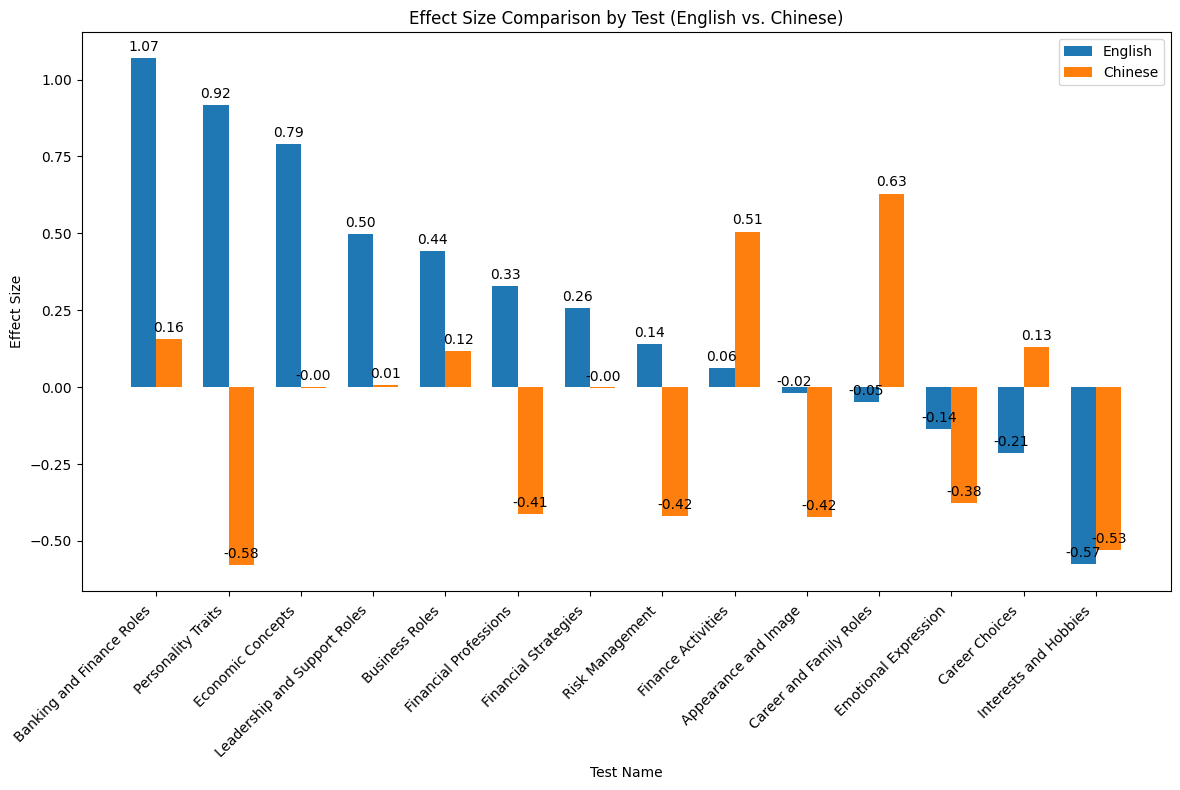

In [60]:
import matplotlib.pyplot as plt
import numpy as np

# Extracting data and preparing the list
test_effects = []

for test in list({result['test_name'].replace(' (cn)', '') for result in results}):
    en_effect_size = next((r['effect_size'] for r in results if r['test_name'] == test), 0)
    cn_effect_size = next((r['effect_size'] for r in results if r['test_name'] == f"{test} (cn)"), 0)
    test_effects.append((test, en_effect_size, cn_effect_size))

# Sort based on English effect size (second element of the tuple)
test_effects.sort(key=lambda x: x[1], reverse=True)

# Unpacking the sorted data
tests, effect_sizes_en, effect_sizes_cn = zip(*test_effects)

# Remove "and Gender" from the test names
tests = [test.replace("and Gender", "") for test in tests]

# Creating the bar plot
x = np.arange(len(tests))  # the label locations
width = 0.35  # the width of the bars

fig, ax = plt.subplots(figsize=(12, 8))
bars_en = ax.bar(x - width/2, effect_sizes_en, width, label='English')
bars_cn = ax.bar(x + width/2, effect_sizes_cn, width, label='Chinese')

# Add some text for labels, title, and custom x-axis tick labels, etc.
ax.set_xlabel('Test Name')
ax.set_ylabel('Effect Size')
ax.set_title('Effect Size Comparison by Test (English vs. Chinese)')
ax.set_xticks(x)
ax.set_xticklabels(tests, rotation=45, ha="right")
ax.legend()

# Function to add labels on top of bars
def add_labels(bars):
    for bar in bars:
        height = bar.get_height()
        if height != 0:  # Only annotate non-zero bars
            ax.annotate(f'{height:.2f}',
                        xy=(bar.get_x() + bar.get_width() / 2, height),
                        xytext=(0, 3),  # 3 points vertical offset
                        textcoords="offset points",
                        ha='center', va='bottom')

add_labels(bars_en)
add_labels(bars_cn)

fig.tight_layout()

plt.show()

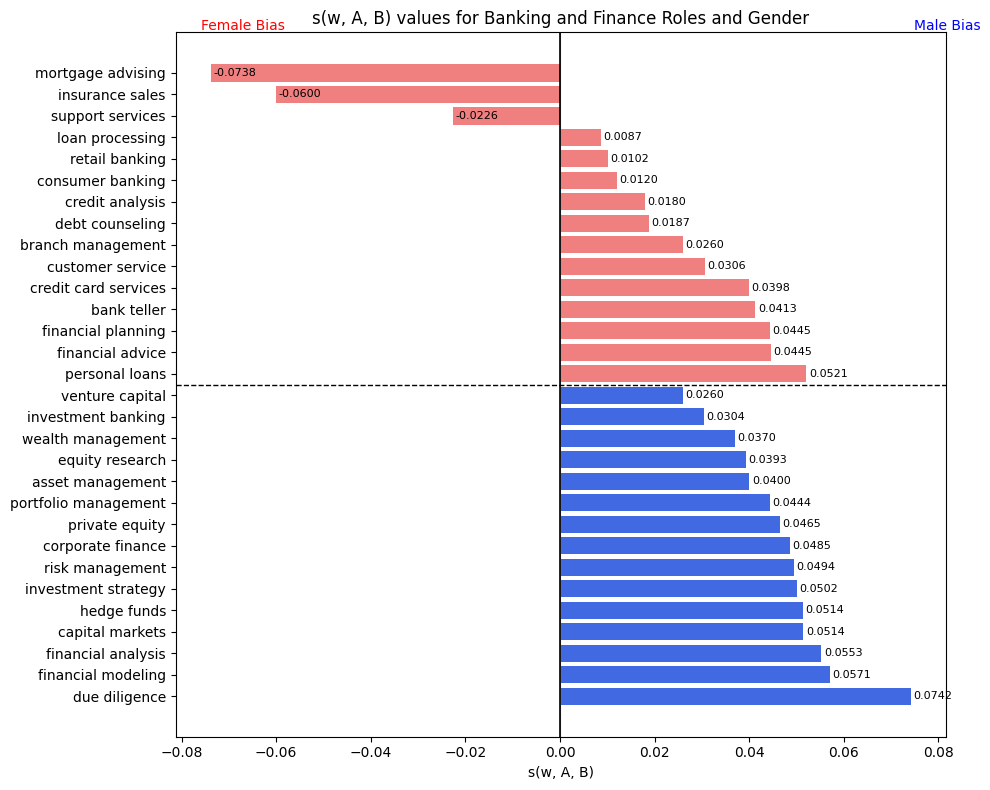

In [61]:
def plot_swab_values(test_name, results):
    # Find the result for the specified test
    result = next((r for r in results if r['test_name'] == test_name), None)
    
    if not result:
        print(f"No result found for {test_name}")
        return
    
    # Sorting the target words based on the s(w, A, B) values
    sorted_indices_target_1 = np.argsort(result['target_1_s_wAB'])[::-1]
    sorted_indices_target_2 = np.argsort(result['target_2_s_wAB'])[::-1]

    # Sorting words and their corresponding s(w, A, B) values
    sorted_target_1_words = [result['target_1_words'][i] for i in sorted_indices_target_1]
    sorted_s_wAB_target_1 = [result['target_1_s_wAB'][i] for i in sorted_indices_target_1]

    sorted_target_2_words = [result['target_2_words'][i] for i in sorted_indices_target_2]
    sorted_s_wAB_target_2 = [result['target_2_s_wAB'][i] for i in sorted_indices_target_2]

    # Combine them into a single list
    sorted_words = sorted_target_1_words + sorted_target_2_words
    sorted_s_wAB = sorted_s_wAB_target_1 + sorted_s_wAB_target_2

    # Plotting
    fig, ax = plt.subplots(figsize=(10, 8))

    # Create the horizontal bar plot
    bars = ax.barh(sorted_words, sorted_s_wAB, color=['royalblue']*len(sorted_s_wAB_target_1) + ['lightcoral']*len(sorted_s_wAB_target_2))

    # Add a vertical line at x=0 for reference
    ax.axvline(0, color='grey', linewidth=0.8)

    # Add labels to the bars
    for i, bar in enumerate(bars):
        ax.text(bar.get_width() + 0.0005, bar.get_y() + bar.get_height()/2,
                f'{sorted_s_wAB[i]:.4f}', va='center', color='black', fontsize=8)
# Separate target_1_words and target_2_words with a horizontal line
    separator_index = len(sorted_target_1_words)
    ax.axhline(separator_index - 0.5, color='black', linestyle='--', linewidth=1)

    # Add titles and labels
    ax.set_xlabel("s(w, A, B)")
    ax.set_title(f"s(w, A, B) values for {test_name}")
    ax.set_yticks(np.arange(len(sorted_words)))
    ax.set_yticklabels(sorted_words)
    ax.axvline(x=0, color='black', linestyle='-', linewidth=1.2)

    # Label the biases
    ax.text(max(sorted_s_wAB) + 0.0005, len(sorted_words) + 1, 'Male Bias', color='blue')
    ax.text(min(sorted_s_wAB) - 0.002, len(sorted_words) + 1, 'Female Bias', color='red')

    # Adjusting the layout to prevent clipping
    fig.tight_layout()

    # Show the plot
    plt.show()

# Example usage:
plot_swab_values("Banking and Finance Roles and Gender", results)

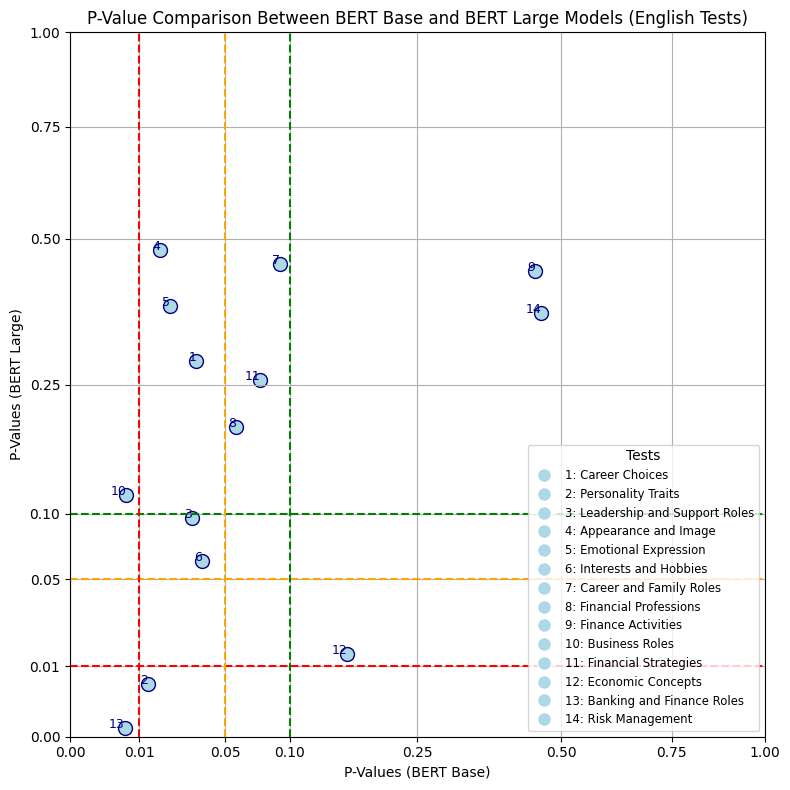

In [62]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import numpy as np

def plot_adjusted_p_values_with_custom_scale(all_results):
    # Filter out the results to only include English tests
    english_results_base = [result for result in all_results['bert-base-uncased'] if not result['test_name'].endswith(' (cn)')]
    english_results_large = [result for result in all_results['bert-large-uncased'] if not result['test_name'].endswith(' (cn)')]

    # Extract the p-values and test names from both models
    p_values_base = [result['p_value'] for result in english_results_base]
    p_values_large = [result['p_value'] for result in english_results_large]
    test_names = [result['test_name'].replace(' and Gender', '') for result in english_results_base]

    # Create the scatter plot
    fig, ax = plt.subplots(figsize=(8, 8))  # Square plot

    # Scatter plot with soft color
    scatter = ax.scatter(p_values_base, p_values_large, color='lightblue', edgecolor='navy', s=100, label='P-Values')
    
    # Annotate each point with its corresponding test name
    for i, name in enumerate(test_names):
        ax.annotate(f"{i+1}", (p_values_base[i], p_values_large[i]), fontsize=9, ha='right', color='navy')

    # Manually set the y-axis range to spread the points out more with non-linear scaling
    ax.set_yscale('function', functions=(np.sqrt, np.square))
    ax.set_xscale('function', functions=(np.sqrt, np.square))

    # Custom ticks for non-linear distribution
    ax.set_xticks([0, 0.01, 0.05, 0.1, 0.25, 0.5, 0.75, 1.0])
    ax.set_yticks([0, 0.01, 0.05, 0.1, 0.25, 0.5, 0.75, 1.0])
    ax.get_xaxis().set_major_formatter(ticker.ScalarFormatter())
    ax.get_yaxis().set_major_formatter(ticker.ScalarFormatter())

    # Plot the significance level lines with separate legend
    ax.axhline(0.01, color='red', linestyle='--')
    ax.axhline(0.05, color='orange', linestyle='--')
    ax.axhline(0.10, color='green', linestyle='--')
    
    ax.axvline(0.01, color='red', linestyle='--')
    ax.axvline(0.05, color='orange', linestyle='--')
    ax.axvline(0.10, color='green', linestyle='--')

    # Set labels and title
    ax.set_xlabel('P-Values (BERT Base)')
    ax.set_ylabel('P-Values (BERT Large)')
    ax.set_title('P-Value Comparison Between BERT Base and BERT Large Models (English Tests)')

    # Add a legend for the significance levels and points
    ax.legend(['1% Significance Level', '5% Significance Level', '10% Significance Level'], loc='upper right', fontsize='small', title="Significance Levels")
    
    # Create a separate legend for the test names
    handles = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='lightblue', markersize=10, label=f"{i+1}: {name}")
               for i, name in enumerate(test_names)]
    plt.legend(handles=handles, loc='lower right', fontsize='small', title="Tests")

    # Show the plot
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# Example usage:
plot_adjusted_p_values_with_custom_scale(all_results)

In [8]:
load_results('/Users/autumnlqerfa/Desktop/财务LLM/论文资料/bias/code/bert-base-uncased_results.json','bert_base')

NameError: name 'json' is not defined